In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import numpy as np
from sklearn import metrics

In [2]:
data = pd.read_csv("/content/marketing_campaign.csv", sep = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
data.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

###There are 24 null/missing values in Income 

In [5]:
# Imputing missing values with mean
data.loc[(data['Income'].isnull() == True), 'Income'] = data['Income'].mean()

###Customer Join Date

In [6]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for value in data["Dt_Customer"]:
    value = value.date()
    dates.append(value)

print("Oldest customer join date: ", min(dates))
print("Newest customer join date:", max(dates))

Oldest customer join date:  2012-07-30
Newest customer join date: 2014-06-29


###Now we will be exploring the unique values in the categorical features

In [7]:
data["Marital_Status"].value_counts()

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [8]:
data["Education"].value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

###Feature Engineering

In [9]:
# Age of customers as of 01/05/2022
data["Age"] = 2022 - data["Year_Birth"]

In [10]:
# Amount spent
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]

In [11]:
#Lliving with situation based on marital status
data["Living_With"] = data["Marital_Status"].replace(
    {"Married": "Partner",
     "Together": "Partner",
     "Absurd": "Alone",
     "Widow": "Alone",
     "YOLO:": "Alone",
     "Divorced": "Alone",
     "Single": "Alone",
     })

In [12]:
data["Children"] = data["Kidhome"] + data["Teenhome"]

In [13]:
data["Is_Parent"] = np.where(data.Children > 0, 1, 0)

In [14]:
data["Education"] = data["Education"].replace(
    {"Basic": "Undergraduate",
     "2n Cycle": "Undergraduate",
     "Graduation": "Graduate",
     "Master": "Postgraduate",
     "PhD": "Postgraduate"}
)

In [15]:
# Drop redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue",
           "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [16]:
data.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,Is_Parent
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,...,0.074554,0.072768,0.064286,0.013393,0.009375,0.149107,53.194196,605.798214,0.950446,0.715179
std,25037.797168,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,...,0.262728,0.259813,0.245316,0.114976,0.096391,0.356274,11.984069,602.249288,0.751803,0.451430
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,5.000000,0.000000,0.000000
25%,35538.750000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,68.750000,0.000000,0.000000
50%,51741.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,396.000000,1.000000,1.000000
75%,68289.750000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000,1045.500000,1.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,129.000000,2525.000000,3.000000,1.000000


###Distribution of the Features

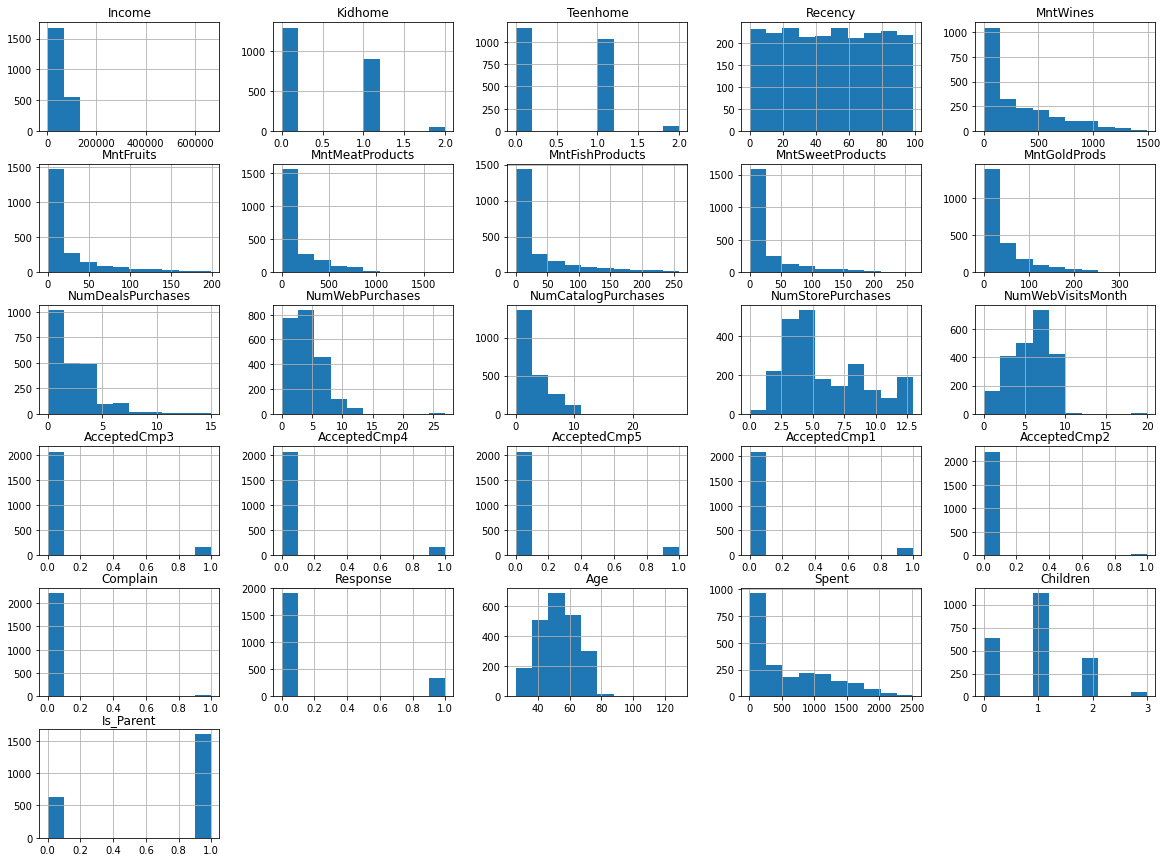

In [17]:
data.hist(figsize=(20,15))
plt.show()

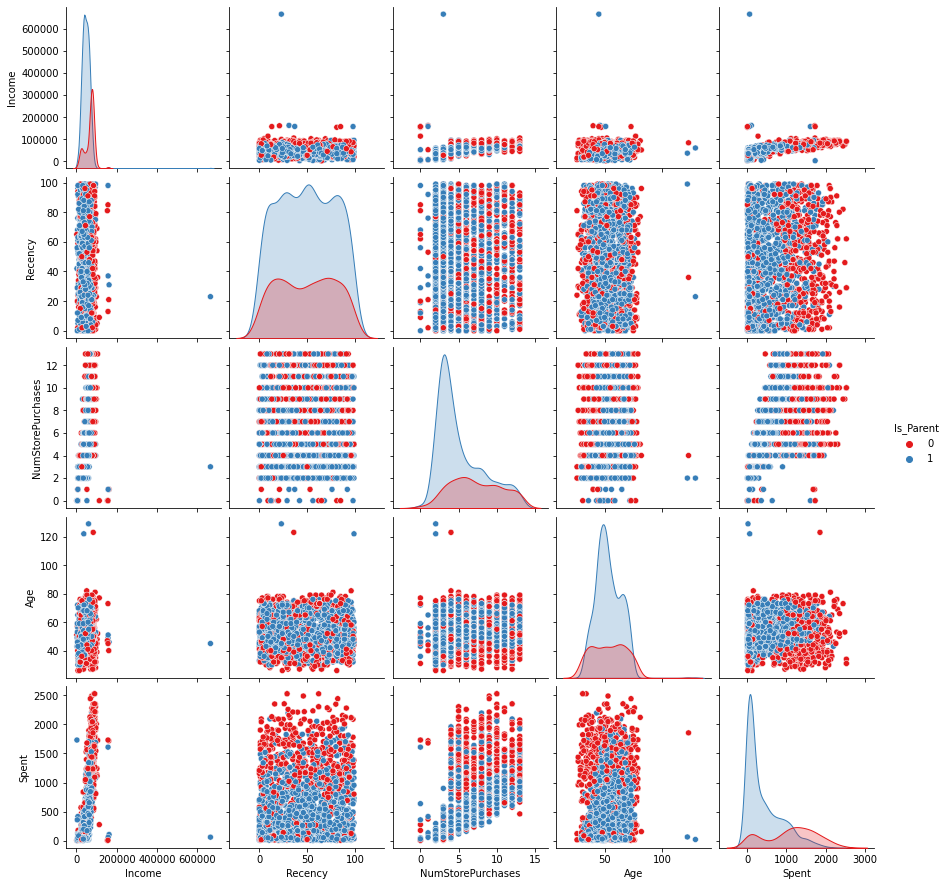

In [18]:
features = ["Income", "Recency", "NumStorePurchases", "Age", "Spent", "Is_Parent"]
sns.pairplot(data[features], hue = "Is_Parent", palette = 'Set1')

In [19]:
# Drop outliers
data = data[(data["Age"] < 90)]
data = data[(data["Income"] < 600000)]

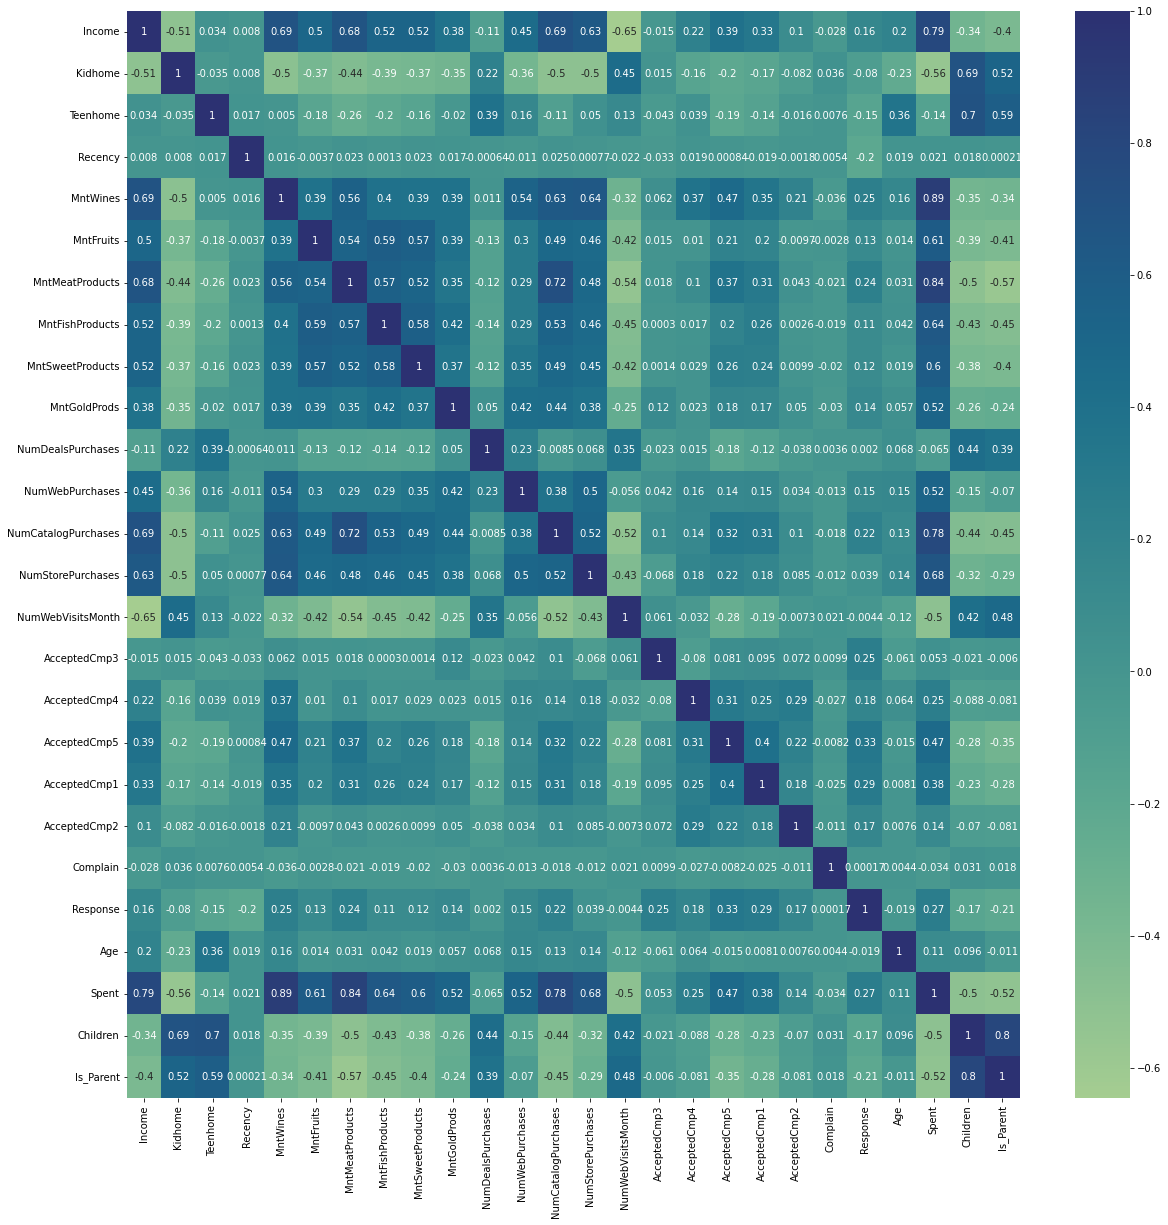

In [20]:
plt.subplots(figsize=(20,20))
corr = data.corr()
sns.heatmap(corr, annot=True,cmap="crest")

In [21]:
cat = (data.dtypes == 'object')
object_cols = list(cat[cat].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [22]:
Enc = LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(Enc.fit_transform)

In [23]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Living_With,Children,Is_Parent
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,0,1,65,1617,0,0,0
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,0,0,68,27,0,2,1
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,0,0,57,776,1,0,0
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,0,0,38,53,1,1,1
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,0,0,41,422,1,1,1


In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data),columns= data.columns )

In [25]:
scaled_data.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Living_With,Children,Is_Parent
0,0.0,0.351086,0.0,0.0,0.585859,0.425318,0.442211,0.316522,0.664093,0.334601,...,0.0,0.0,0.0,0.0,1.0,0.696429,0.639683,0.0,0.000000,0.0
1,0.0,0.277680,0.5,0.5,0.383838,0.007368,0.005025,0.003478,0.007722,0.003802,...,0.0,0.0,0.0,0.0,0.0,0.750000,0.008730,0.0,0.666667,1.0
2,0.0,0.434956,0.0,0.0,0.262626,0.285332,0.246231,0.073623,0.428571,0.079848,...,0.0,0.0,0.0,0.0,0.0,0.553571,0.305952,0.5,0.000000,0.0
3,0.0,0.155079,0.5,0.0,0.262626,0.007368,0.020101,0.011594,0.038610,0.011407,...,0.0,0.0,0.0,0.0,0.0,0.214286,0.019048,0.5,0.333333,1.0
4,0.5,0.352051,0.5,0.0,0.949495,0.115874,0.216080,0.068406,0.177606,0.102662,...,0.0,0.0,0.0,0.0,0.0,0.267857,0.165476,0.5,0.333333,1.0


###Calculating Silhouette_score

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

For n_clusters = 4 The average silhouette_score is : 0.18522399803878842
For n_clusters = 5 The average silhouette_score is : 0.18919687213416259
For n_clusters = 6 The average silhouette_score is : 0.1438980807803187
For n_clusters = 7 The average silhouette_score is : 0.14434612672157568
For n_clusters = 8 The average silhouette_score is : 0.1551514830161908
For n_clusters = 9 The average silhouette_score is : 0.15742218021301269
For n_clusters = 10 The average silhouette_score is : 0.1514967377278158
For n_clusters = 11 The average silhouette_score is : 0.15712570372294551
For n_clusters = 12 The average silhouette_score is : 0.16677473540911483
For n_clusters = 13 The average silhouette_score is : 0.16299300439454978
For n_clusters = 14 The average silhouette_score is : 0.1713551479678883
For n_clusters = 15 The average silhouette_score is : 0.16159103209160652


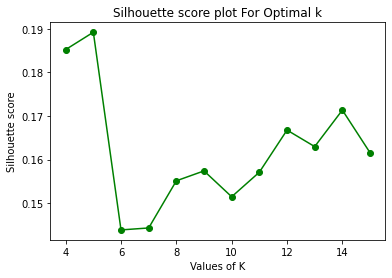

In [27]:
def findBestN(matrix):
  silhouettescore_avg = []
  range_n_clusters = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  for n in range_n_clusters:
    kmeans = KMeans(n_clusters = n, n_init=20, random_state=0)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n, "The average silhouette_score is :", silhouette_avg)
    silhouettescore_avg.append(silhouette_score(matrix, cluster_labels))
  plt.plot(range_n_clusters,silhouettescore_avg,'go-')
  plt.xlabel('Values of K') 
  plt.ylabel('Silhouette score') 
  plt.title('Silhouette score plot For Optimal k')
  plt.show()    
findBestN(scaled_data)

###Elbow Plot

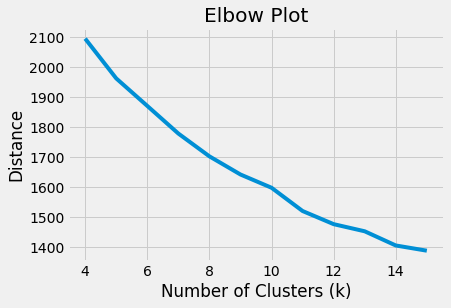

In [28]:
import matplotlib.style as style

range_n_clusters = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
avg_distance=[]
for n_clusters in range_n_clusters:
  cluster = KMeans(n_clusters=n_clusters, random_state=0).fit(scaled_data)
  avg_distance.append(cluster.inertia_)

style.use("fivethirtyeight")
plt.plot(range_n_clusters, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.title("Elbow Plot")
plt.show()

###From the above Silhouette_score plot and Elbow Plot, it is reasonable to assume that number of clusters = 5 is a decent value for the given data

In [29]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(scaled_data)
predictions = kmeans.predict(scaled_data)

data['cluster_group'] = predictions + 1

In [30]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Living_With,Children,Is_Parent,cluster_group
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,1,65,1617,0,0,0,5
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,0,68,27,0,2,1,2
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,0,57,776,1,0,0,1
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,0,38,53,1,1,1,2
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,0,41,422,1,1,1,2


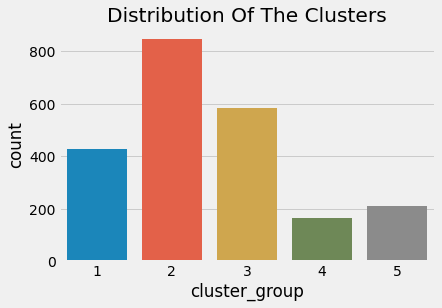

In [31]:
cl = sns.countplot(x=data["cluster_group"])
cl.set_title("Distribution Of The Clusters")
plt.show()

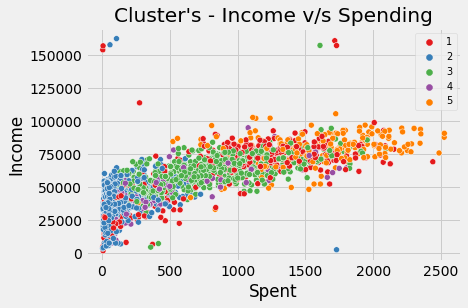

In [32]:
clt = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["cluster_group"], palette = 'Set1')
clt.set_title("Cluster's - Income v/s Spending")
plt.legend(loc = 'upper right', fontsize = 'x-small')
plt.show()

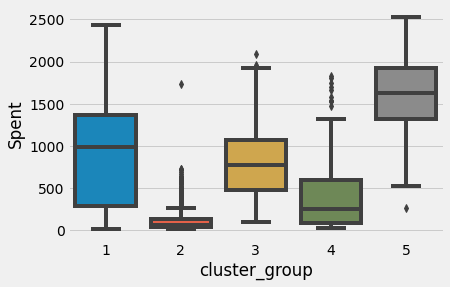

In [33]:
cl=sns.boxplot(x=data["cluster_group"], y=data["Spent"])
plt.show()

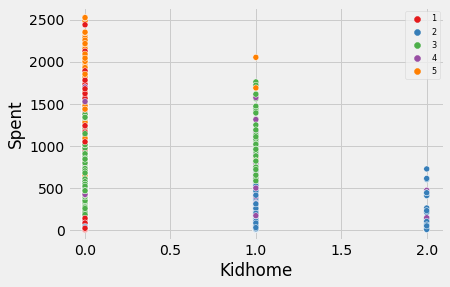

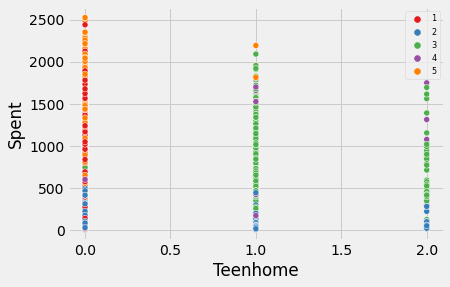

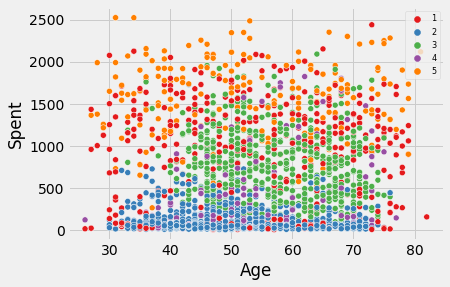

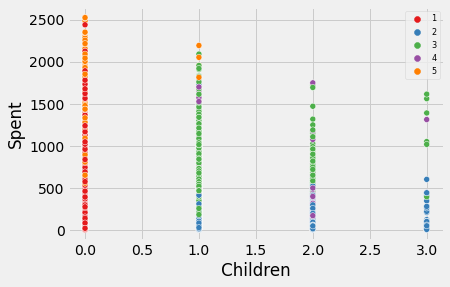

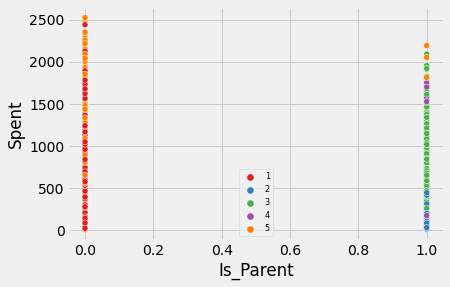

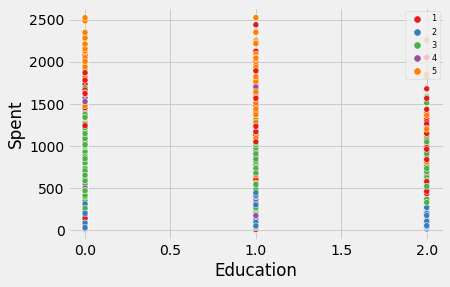

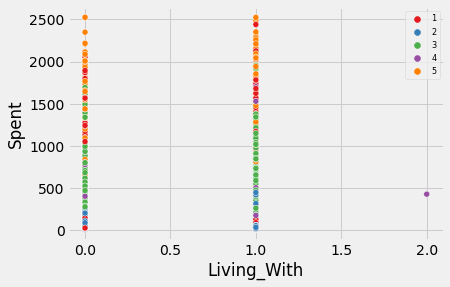

In [34]:
Combined = [ "Kidhome","Teenhome", "Age", "Children", "Is_Parent", "Education","Living_With"]

for i in Combined:
    plt.figure()
    sns.scatterplot(x=data[i], y=data["Spent"], hue =data["cluster_group"], palette = 'Set1')
    plt.legend(loc = 'best',fontsize = 'xx-small')
    plt.show()